# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

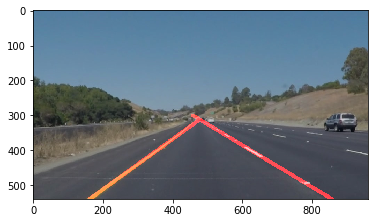

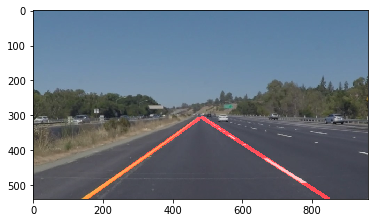

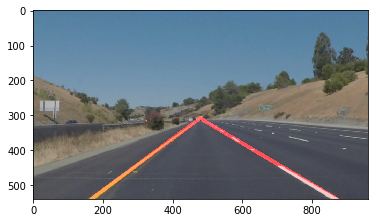

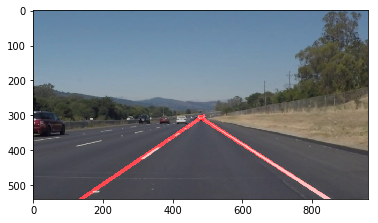

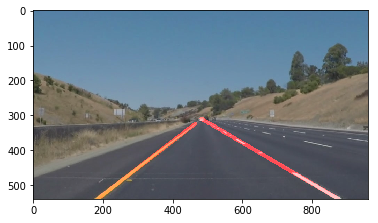

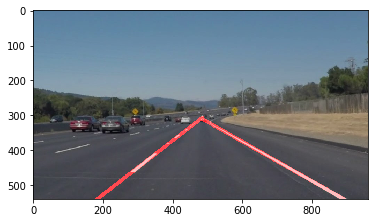

In [26]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline


def extendLine(img, x1,y1, x2, y2):
    """
    extend the provided coordinates to the end of the bottom of the image
    we calculate the slope fomr the coordinates provded. 
    and we use that value to solve the equation for the intersection of line with 
    the bottom line (y= bottom_of_the_Image)
    """
    imshape = img.shape
    slope = (y2-y1)/(x2-x1)
    x = int(round((imshape[0] - y2)/slope + x2))
    if y2 > y1:
        return x1,y1,x,imshape[0]
    else : 
        return x, imshape[0], x2, y2
    

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    draws a two lines from the list of the detected segements.
    we check the slop of each segemnts to separate them into left and right
    we average the values of each coordonates 
    we extend the lines to the bottom of the image
    """
    imshape = img.shape
    
    # initialize the coordinates of the mmost representative segemnt for each lines
    left_x1 = 0
    left_y1 = 0
    left_x2 = 0
    left_y2 = 0
    left_count = 0
    
    right_x1 = 0
    right_y1 = 0
    right_x2 = 0
    right_y2 = 0
    right_count = 0
    
    # summing the values of the coordinates in order to compute the average
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if (slope < 0) : # left line
                left_x1 = left_x1 + x1
                left_y1 = left_y1 + y1
                left_x2 = left_x2 + x2
                left_y2 = left_y2 + y2
                
                left_count = left_count + 1
            else : # right lane
                right_x1 = right_x1 + x1
                right_y1 = right_y1 + y1
                right_x2 = right_x2 + x2
                right_y2 = right_y2 + y2
                
                right_count = right_count + 1
                
    # compute the coordiantes of the most representative segemnts 
    # then extend it to the bottom of the image            
    
    if left_count > 0 :
        left_x1 = int(round(left_x1/left_count))
        left_y1 = int(round(left_y1/left_count))
        left_x2 = int(round(left_x2/left_count))
        left_y2 = int(round(left_y2/left_count))

        left_x1, left_y1, left_x2, left_y2 = extendLine(img, left_x1, left_y1, left_x2, left_y2)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)


    if right_count > 0 :
        right_x1 = int(round(right_x1/right_count))
        right_y1 = int(round(right_y1/right_count))
        right_x2 = int(round(right_x2/right_count))
        right_y2 = int(round(right_y2/right_count))

        right_x1, right_y1, right_x2, right_y2 = extendLine(img, right_x1, right_y1, right_x2, right_y2)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
                

def processImage(image):
    """
    marks the image with the lines 
    """
    # Read in and grayscale the image
    #image = mpimg.imread('exit-ramp.jpg')
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    bottom_left  = (100, imshape[0]) 
    top_left     = (430, 300) #(0,0)
    top_right    = (550, 300) #(imshape[1], 0)
    bottom_right = (imshape[1] - 60,imshape[0])

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right ]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 175 #minimum number of pixels making up a line
    max_line_gap = 100   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
     
    # draw the lines on the image 
    draw_lines(line_image, lines, (255,0,0), 10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    #plt.imshow(lines_edges)
    return lines_edges

def showImage(image):
    plt.figure()
    #plt.imshow(image)
    plt.imshow(image, cmap='gray')
    
imagefolder = 'test_images/'

# testing the pipeline on the images in tge the test folder
for imagePath in [ imagefolder + image for image in os.listdir(imagefolder) ]:
    image = mpimg.imread(imagePath)
    processed = processImage(image)
    showImage(processed)



You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    result = processImage(image)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.21 s, sys: 377 ms, total: 2.58 s
Wall time: 3.01 s



100%|█████████▉| 221/222 [00:02<00:00, 83.26it/s]

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.74 s, sys: 879 ms, total: 7.62 s
Wall time: 7.96 s



100%|█████████▉| 681/682 [00:07<00:00, 89.34it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [16]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.48 s, sys: 647 ms, total: 6.13 s
Wall time: 6.96 s



100%|██████████| 251/251 [00:06<00:00, 39.25it/s]


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))